In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from Data_manager.split_functions.split_train_validation_random_holdout import \
        split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *

In [2]:
URM = createURM()

/Users/matteopancini/PycharmProjects/recsys-challenge-2022-Pancini-Vitali/Utils/recsys2022DataReader.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [3]:
ICM = createSmallICM()

In [4]:
profile_length = np.ediff1d(URM.indptr)
profile_length, profile_length.shape

(array([ 66,  21, 103, ...,  23,  53,  23], dtype=int32), (41629,))

In [5]:
block_size = int(len(profile_length)*0.25)
block_size

10407

In [6]:
sorted_users = np.argsort(profile_length)
sorted_users

array([38400, 30257, 25061, ..., 19407,  8693, 12454])

In [7]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

In [8]:
for group_id in range(0, 4):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 10407, average p.len 17.42, median 18.0, min 5, max 21
Group 1, #users in group 10407, average p.len 24.78, median 25.0, min 21, max 29
Group 2, #users in group 10407, average p.len 34.40, median 34.0, min 29, max 42
Group 3, #users in group 10407, average p.len 72.67, median 59.0, min 42, max 1176


In [9]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "IALSRecommender": IALSRecommender,
                                   "SlimElasticNet": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    if(label == 'ItemKNNCF'):
        recommender_object.fit(ICM=ICM*58, shrink=1665.2431108249625, topK=3228, similarity='dice',
                                                  feature_weighting='bm25', normalization='bm25')
    elif(label == 'P3alpha'):
        recommender_object.fit(topK=218, alpha=0.8561168568686058)
    elif(label == 'RP3beta'):
        recommender_object.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
    elif(label == 'IALSRecommender'):
        recommender_object.fit(epochs=94, num_factors=287, alpha=10, reg=0.01)
    elif(label == 'SlimElasticNet'):
        recommender_object.fit(topK=359, alpha=0.04183472018614359, l1_ratio=0.03260349571135893)
    else:
        recommender_object.fit()


    recommender_object_dict[label] = recommender_object

Done: 100%|██████████| 24507/24507 [00:16<00:00, 1481.95it/s]            


P3alphaRecommender: Similarity column 24507 (100.0%), 2992.46 column/sec. Elapsed time 8.19 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 3698.77 column/sec. Elapsed time 6.63 sec
IALSRecommender: Epoch 1 of 94. Elapsed time 3.20 min


KeyboardInterrupt: 

In [15]:
cutoff = 10
from Evaluation.Evaluator import EvaluatorHoldout

for group_id in range(0, 4):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id,
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))


    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 10407, average p.len 17.42, median 18.0, min 5, max 21
EvaluatorHoldout: Ignoring 952 ( 2.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
Deallocating Cython objects
EvaluatorHoldout: Processed 9688 (100.0%) in 5.82 sec. Users per second: 1663
EvaluatorHoldout: Processed 9688 (100.0%) in 4.31 sec. Users per second: 2250
EvaluatorHoldout: Processed 9688 (100.0%) in 4.24 sec. Users per second: 2283
EvaluatorHoldout: Processed 9688 (100.0%) in 4.15 sec. Users per second: 2335
EvaluatorHoldout: Processed 9688 (100.0%) in 4.35 sec. Users per second: 2226
EvaluatorHoldout: Processed 9688 (100.0%) in 3.87 sec. Users per second: 2506
Group 1, #users in group 10407, average p.len 24.78, median 25.0, min 21, max 29
EvaluatorHoldout: Ignoring 952 ( 2.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 31222 Users
EvaluatorHoldout: Processed 10214 (100.0%) in 5.91 sec. Users per second: 1727
EvaluatorHoldout

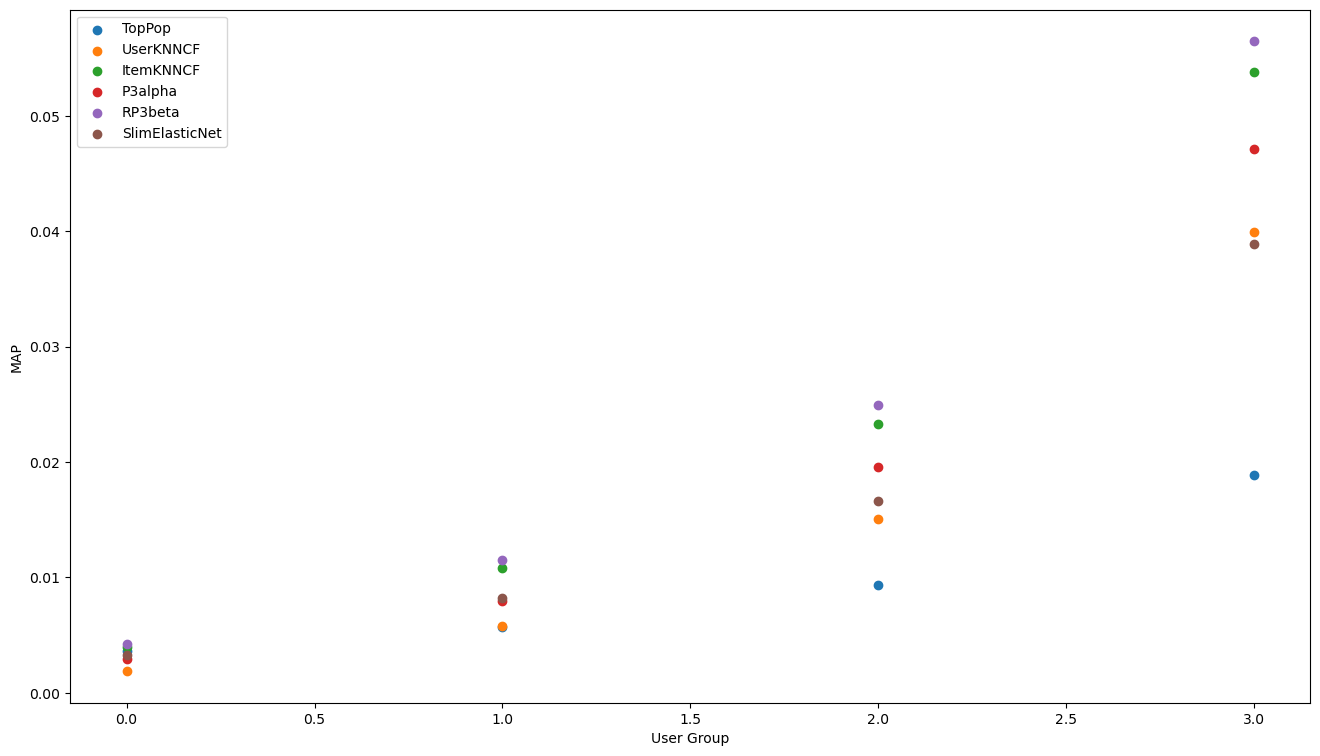

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()